In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
import shap
import glob

C:\Users\Robin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Chargement des données
folder_path = "data/all"  # Adapter au chemin correct
csv_files = glob.glob(f"{folder_path}/*.csv")
dataframes = [pd.read_csv(file) for file in csv_files]
data = pd.concat(dataframes, ignore_index=True)


In [3]:

# Affichage des informations de base
print("Aperçu des données initiales:")
print(data.head())
print(data.info())

Aperçu des données initiales:
                          listing_url  bathrooms  bedrooms  accommodates  \
0   https://www.airbnb.com/rooms/3109        1.0       1.0             2   
1  https://www.airbnb.com/rooms/80301        1.5       1.0             1   
2   https://www.airbnb.com/rooms/5396        1.0       0.0             2   
3   https://www.airbnb.com/rooms/7397        1.0       2.0             4   
4  https://www.airbnb.com/rooms/80327        1.0       1.0             1   

  bathrooms_text  beds                property_type        room_type  \
0         1 bath   0.0           Entire rental unit  Entire home/apt   
1      1.5 baths   1.0  Private room in rental unit     Private room   
2         1 bath   1.0           Entire rental unit  Entire home/apt   
3         1 bath   1.0           Entire rental unit  Entire home/apt   
4         1 bath   1.0                 Entire condo  Entire home/apt   

   latitude  longitude neighbourhood_cleansed  minimum_nights  maximum_nights  \

In [4]:
# Préparation des données
selected_columns = [
    'neighbourhood_cleansed', 'latitude', 'longitude', 
    'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'price',
    'minimum_nights', 'maximum_nights', 'instant_bookable', 'availability_365'
]
data = data[selected_columns]

In [5]:
data

,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,instant_bookable,availability_365
0,Observatoire,48.831910,2.318700,Entire rental unit,Entire home/apt,2,1.0,1.0,0.0,250.0,2,30,t,349
1,Panthéon,48.839180,2.346990,Private room in rental unit,Private room,1,1.5,1.0,1.0,60.0,30,190,f,145
2,Hôtel-de-Ville,48.852470,2.358350,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,96.0,2,1125,f,154
3,Hôtel-de-Ville,48.859090,2.353150,Entire rental unit,Entire home/apt,4,1.0,2.0,1.0,160.0,10,130,f,277
4,Buttes-Montmartre,48.889120,2.361540,Entire condo,Entire home/apt,1,1.0,1.0,1.0,48.0,4,60,f,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187255,Opéra,48.876980,2.343230,Private room in rental unit,Private room,4,1.0,1.0,1.0,114.0,1,365,f,0
187256,Entrepôt,48.874400,2.371717,Entire rental unit,Entire home/apt,4,1.0,1.0,1.0,100.0,3,60,f,362
187257,Passy,48.838180,2.257970,Entire rental unit,Entire home/apt,4,1.0,1.0,2.0,77.0,1,365,t,18
187258,Batignolles-Monceau,48.875698,2.289969,Entire rental unit,Entire home/apt,6,2.5,3.0,3.0,640.0,2,365,t,356


In [6]:
# Traitement des valeurs aberrantes
price_q1, price_q3 = np.percentile(data['price'], [25, 75])
iqr = price_q3 - price_q1
lower_bound = price_q1 - 1.5 * iqr
upper_bound = price_q3 + 1.5 * iqr
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]


In [7]:
# Assurez-vous que 'data' est une copie indépendante avant de le modifier
data = data.copy()

# Création de nouvelles variables
data['bedrooms_per_bed'] = data['bedrooms'] / data['beds'].replace(0, np.nan)
data['accommodates_per_bathroom'] = data['accommodates'] / data['bathrooms'].replace(0, np.nan)
data['accommodates_bedrooms'] = data['accommodates'] * data['bedrooms']


In [8]:
# Gestion des outliers pour 'minimum_nights' et 'maximum_nights'
for col in ['minimum_nights', 'maximum_nights']:
    if col in data.columns:
        q1, q3 = data[col].quantile(0.25), data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [9]:
data.loc[:, 'price'] = np.log1p(data['price'])


In [10]:
data

,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,instant_bookable,availability_365,bedrooms_per_bed,accommodates_per_bathroom,accommodates_bedrooms
0,Observatoire,48.831910,2.318700,Entire rental unit,Entire home/apt,2,1.0,1.0,0.0,5.525453,2,30,t,349,NaN,2.0,2.0
4,Buttes-Montmartre,48.889120,2.361540,Entire condo,Entire home/apt,1,1.0,1.0,1.0,3.891820,4,60,f,140,1.0,1.0,1.0
5,Opéra,48.874170,2.342450,Entire rental unit,Entire home/apt,3,1.0,2.0,2.0,5.198497,7,365,f,32,1.0,3.0,6.0
7,Popincourt,48.863730,2.370930,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,5.135798,4,31,f,105,1.0,2.0,2.0
8,Entrepôt,48.884400,2.360910,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,4.836282,7,13,f,80,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187254,Hôtel-de-Ville,48.850912,2.354879,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,4.948760,1,365,t,286,0.0,2.0,0.0
187255,Opéra,48.876980,2.343230,Private room in rental unit,Private room,4,1.0,1.0,1.0,4.744932,1,365,f,0,1.0,4.0,4.0
187256,Entrepôt,48.874400,2.371717,Entire rental unit,Entire home/apt,4,1.0,1.0,1.0,4.615121,3,60,f,362,1.0,4.0,4.0
187257,Passy,48.838180,2.257970,Entire rental unit,Entire home/apt,4,1.0,1.0,2.0,4.356709,1,365,t,18,0.5,4.0,4.0


In [11]:
categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'instant_bookable']
num_features = [
    'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 
    'beds', 'minimum_nights', 'maximum_nights', 'availability_365',
    'bedrooms_per_bed', 'accommodates_per_bathroom', 'accommodates_bedrooms'
]

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

In [13]:
# Séparation des données
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

In [15]:
# Modèles à évaluer
models = {
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42, thread_count=-1),
    'Ridge': Ridge(random_state=42)
}


In [16]:
print(X_train.isnull().sum())


neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
minimum_nights               0
maximum_nights               0
instant_bookable             0
availability_365             0
bedrooms_per_bed             0
accommodates_per_bathroom    0
accommodates_bedrooms        0
dtype: int64


In [17]:
# Entraînement et évaluation des modèles
model_scores = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    mean_cv_score = -np.mean(cv_scores)
    model_scores[name] = mean_cv_score
    print(f"{name}: Cross-Validated MAE = {mean_cv_score:.4f}")


RandomForest: Cross-Validated MAE = 0.2492
XGBoost: Cross-Validated MAE = 0.2851
LightGBM: Cross-Validated MAE = 0.2905
CatBoost: Cross-Validated MAE = 0.2858
Ridge: Cross-Validated MAE = 0.3111


In [18]:
# Modèle avec le meilleur MAE
best_model_name = min(model_scores, key=model_scores.get)
best_model_class = models[best_model_name]
print(f"Meilleur modèle: {best_model_name} avec MAE = {model_scores[best_model_name]:.4f}")


Meilleur modèle: RandomForest avec MAE = 0.2492


In [ ]:
# # Ajustement final du meilleur modèle avec GridSearchCV pour tous les modèles
# from sklearn.utils import estimator_html_repr

# # Définir les grilles d'hyperparamètres pour différents modèles
# param_grids = {
#     'RandomForestRegressor': {
#         'model__n_estimators': [50, 100],
#         'model__max_depth': [None, 10, 20]
#     },
#     'XGBRegressor': {
#         'model__learning_rate': [0.01, 0.1],
#         'model__n_estimators': [100, 200],
#         'model__max_depth': [3, 5]
#     },
#     'LGBMRegressor': {
#         'model__learning_rate': [0.01, 0.1],
#         'model__n_estimators': [100, 200],
#         'model__num_leaves': [31, 50]
#     },
#     'CatBoostRegressor': {
#         'model__depth': [4, 6],
#         'model__learning_rate': [0.01, 0.1],
#         'model__iterations': [100, 200]
#     }
# }

# # Extraire le nom du modèle
# model_name = type(best_model_class).__name__

# # Vérifier si le modèle a une grille définie, sinon utiliser la configuration par défaut
# param_grid = param_grids.get(model_name, {})

# # Exécuter GridSearchCV uniquement si une grille est disponible
# if param_grid:
#     grid_search = GridSearchCV(
#         estimator=Pipeline(steps=[
#             ('preprocessor', preprocessor),
#             ('model', best_model_class)
#         ]),
#         param_grid=param_grid,
#         cv=5,  # Validation croisée à 5 plis
#         scoring='neg_mean_absolute_error',
#         n_jobs=-1,
#         verbose=1
#     )
#     grid_search.fit(X_train, y_train)
#     best_model = grid_search.best_estimator_
#     print(f"Meilleurs hyperparamètres pour {model_name} : {grid_search.best_params_}")
# else:
#     # Si aucune grille n'est définie, entraîner directement le modèle
#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('model', best_model_class)
#     ])
#     pipeline.fit(X_train, y_train)
#     best_model = pipeline
#     print(f"Aucune grille d'hyperparamètres définie pour {model_name}. Modèle entraîné sans optimisation.")


In [20]:
# Ajustement final du meilleur modèle avec GridSearchCV pour tous les modèles
from sklearn.utils import estimator_html_repr

# Définir les grilles d'hyperparamètres pour différents modèles
param_grids = {
    'RandomForestRegressor': {
        'model__n_estimators': [50],
        'model__max_depth': [None, 10]
    },
    'XGBRegressor': {
        'model__learning_rate': [0.01],
        'model__n_estimators': [100],
        'model__max_depth': [3]
    },
    'LGBMRegressor': {
        'model__learning_rate': [0.01],
        'model__n_estimators': [100],
        'model__num_leaves': [31]
    },
    'CatBoostRegressor': {
        'model__depth': [4],
        'model__learning_rate': [0.01],
        'model__iterations': [100]
    }
}

# Extraire le nom du modèle
model_name = type(best_model_class).__name__

# Vérifier si le modèle a une grille définie, sinon utiliser la configuration par défaut
param_grid = param_grids.get(model_name, {})

# Exécuter GridSearchCV uniquement si une grille est disponible
if param_grid:
    grid_search = GridSearchCV(
        estimator=Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', best_model_class)
        ]),
        param_grid=param_grid,
        cv=5,  # Validation croisée à 5 plis
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Meilleurs hyperparamètres pour {model_name} : {grid_search.best_params_}")
else:
    # Si aucune grille n'est définie, entraîner directement le modèle
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', best_model_class)
    ])
    pipeline.fit(X_train, y_train)
    best_model = pipeline
    print(f"Aucune grille d'hyperparamètres définie pour {model_name}. Modèle entraîné sans optimisation.")

# Redéfinir `pipeline` pour contenir le meilleur modèle entraîné
pipeline = best_model


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres pour RandomForestRegressor : {'model__max_depth': None, 'model__n_estimators': 50}


In [21]:
print(X_test.isnull().sum())  # Vérifiez si X_test contient des NaN
print(X_test.describe())  # Vérifiez les valeurs aberrantes


neighbourhood_cleansed          0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
minimum_nights                  0
maximum_nights                  0
instant_bookable                0
availability_365                0
bedrooms_per_bed             3087
accommodates_per_bathroom      85
accommodates_bedrooms           0
dtype: int64
           latitude     longitude  accommodates     bathrooms      bedrooms  \
count  23988.000000  23988.000000  23988.000000  23988.000000  23988.000000   
mean      48.864407      2.345176      3.172378      1.125313      1.221569   
std        0.018694      0.034524      1.469982      0.373364      0.725724   
min       48.816090      2.234590      1.000000      0.000000      0.000000   
25%       48.850345      2.323293      2.000000 

In [22]:
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]
print(X_test.isnull().sum())  # Vérifiez si X_test contient des NaN
print(X_test.describe())  # Vérifiez les valeurs aberrantes


neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
minimum_nights               0
maximum_nights               0
instant_bookable             0
availability_365             0
bedrooms_per_bed             0
accommodates_per_bathroom    0
accommodates_bedrooms        0
dtype: int64
           latitude     longitude  accommodates     bathrooms      bedrooms  \
count  20838.000000  20838.000000  20838.000000  20838.000000  20838.000000   
mean      48.864359      2.345173      3.216959      1.136074      1.241770   
std        0.018633      0.034405      1.497068      0.374757      0.736868   
min       48.816090      2.234590      1.000000      0.500000      0.000000   
25%       48.850453      2.323443      2.000000      1.000000      1.000000   
50%       48.8658

In [23]:
# Prédictions et évaluation
y_pred = np.expm1(pipeline.predict(X_test))
y_test_actual = np.expm1(y_test)
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"MAE sur le jeu de test avec {best_model_name}: {mae:.4f}")


MAE sur le jeu de test avec RandomForest: 42.4839


In [24]:
# Ajout d'un modèle Deep Learning
# Conversion en tableau dense (NumPy array)
X_train_scaled = preprocessor.fit_transform(X_train).toarray()
X_test_scaled = preprocessor.transform(X_test).toarray()


In [25]:
dl_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Sortie pour la régression
])
dl_model.compile(optimizer='adam', loss='mean_absolute_error')
dl_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)




Epoch 1/50

2089/2089 [==============================] - 4s 1ms/step - loss: 0.6187 - val_loss: 0.3311
Epoch 2/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.4814 - val_loss: 0.3167
Epoch 3/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.4347 - val_loss: 0.3178
Epoch 4/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.3992 - val_loss: 0.3085
Epoch 5/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.3720 - val_loss: 0.3068
Epoch 6/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.3525 - val_loss: 0.3126
Epoch 7/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.3382 - val_loss: 0.3030
Epoch 8/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.3275 - val_loss: 0.3022
Epoch 9/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.3196 - val_loss: 0.3020
Epoch 10/50
2089/2089 [==============================] - 2s 1ms/step - loss: 0.

In [26]:
# Prédictions avec le modèle DL
y_pred_dl = dl_model.predict(X_test_scaled).flatten()
y_pred_dl_actual = np.expm1(y_pred_dl)
mae_dl = mean_absolute_error(y_test_actual, y_pred_dl_actual)
print(f"MAE avec Deep Learning: {mae_dl:.4f}")

652/652 [==============================] - 0s 610us/step
MAE avec Deep Learning: 51.6929


Taille de 'errors': (20838,)
Quelques valeurs de 'errors': 155833    -10.515148
37594      12.838808
158371     -3.097984
92107     -20.998466
16907     -43.273537
160929    -16.892310
175164    111.898312
177462      1.722874
118317     -3.407306
184781     19.240633
Name: price, dtype: float64


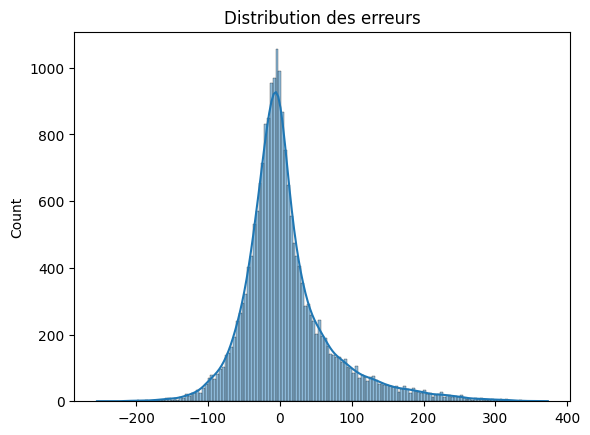

In [27]:
# Visualisation des erreurs
errors = y_test_actual - y_pred
print(f"Taille de 'errors': {errors.shape}")
print(f"Quelques valeurs de 'errors': {errors[:10]}")
errors_np = errors.to_numpy()
sns.histplot(errors_np, kde=True)
plt.title('Distribution des erreurs')
plt.show()


In [28]:
# Stacking de modèles
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42))
]

In [29]:
stack_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(random_state=42))
stack_model.fit(X_train_scaled, y_train)
y_pred_stack = stack_model.predict(X_test_scaled)
mae_stack = mean_absolute_error(y_test_actual, np.expm1(y_pred_stack))
print(f"MAE avec Stacking: {mae_stack:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 83554, number of used features: 63
[LightGBM] [Info] Start training from score 5.056330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 66843, number of used features: 62
[LightGBM] [Info] Start training from score 5.056047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [30]:
import pandas as pd

# Calcul des pourcentages de réussite
error_margin = 0.10  # 10% de marge d'erreur
within_margin = np.abs((y_pred - y_test_actual) / y_test_actual) <= error_margin
success_rate = within_margin.mean() * 100

print(f"Pourcentage de prédictions correctes (marge de ±10%): {success_rate:.2f}%")

# Exporter les prix réels et estimés dans un fichier CSV
results_df = pd.DataFrame({
    'Prix Réel': y_test_actual,
    'Prix Estimé': y_pred,
    'Erreur': y_test_actual - y_pred,
    'Précision (%)': 100 - (np.abs((y_test_actual - y_pred) / y_test_actual) * 100)
})

# Exporter vers un fichier CSV
results_df.to_csv('predictions_results.csv', index=False, float_format='%.2f')
print("Les résultats ont été exportés dans le fichier 'predictions_results.csv'.")


Pourcentage de prédictions correctes (marge de ±10%): 31.39%
Les résultats ont été exportés dans le fichier 'predictions_results.csv'.


In [31]:
# Échantillon des valeurs réelles et prédites
results_sample = pd.DataFrame({
    'Prix Réel': y_test_actual[:10],
    'Prix Estimé': y_pred[:10],
    'Erreur Absolue': np.abs(y_test_actual[:10] - y_pred[:10])
})
print(results_sample)


        Prix Réel  Prix Estimé  Erreur Absolue
155833       91.0   101.515148       10.515148
37594       160.0   147.161192       12.838808
158371      150.0   153.097984        3.097984
92107       216.0   236.998466       20.998466
16907        92.0   135.273537       43.273537
160929      379.0   395.892310       16.892310
175164      280.0   168.101688      111.898312
177462       95.0    93.277126        1.722874
118317      250.0   253.407306        3.407306
184781      216.0   196.759367       19.240633


In [32]:
import joblib

# Exporter le pipeline complet avec joblib
joblib_file = "best_model_pipeline.pkl"
joblib.dump(pipeline, joblib_file)

print(f"Modèle exporté avec succès dans le fichier '{joblib_file}'.")


Modèle exporté avec succès dans le fichier 'best_model_pipeline.pkl'.


In [33]:
# Générer des fausses données
fake_data = pd.DataFrame([{
    "neighbourhood_cleansed": "Observatoire",
    "latitude": 48.831910,
    "longitude": 2.318700,
    "property_type": "Entire rental unit",
    "room_type": "Entire home/apt",
    "accommodates": 2,
    "bathrooms": 1.0,
    "bedrooms": 1.0,
    "beds": 1.0,
    "minimum_nights": 2,
    "maximum_nights": 30,
    "instant_bookable": "t",
    "availability_365": 297
}, {
    "neighbourhood_cleansed": "Hôtel-de-Ville",
    "latitude": 48.852470,
    "longitude": 2.358350,
    "property_type": "Private room in apartment",
    "room_type": "Private room",
    "accommodates": 1,
    "bathrooms": 1.0,
    "bedrooms": 0.0,
    "beds": 1.0,
    "minimum_nights": 1,
    "maximum_nights": 365,
    "instant_bookable": "f",
    "availability_365": 100
}])

# Ajouter les colonnes manquantes en effectuant les mêmes calculs que lors de la préparation des données
fake_data['bedrooms_per_bed'] = fake_data['bedrooms'] / fake_data['beds'].replace(0, np.nan)
fake_data['accommodates_per_bathroom'] = fake_data['accommodates'] / fake_data['bathrooms'].replace(0, np.nan)
fake_data['accommodates_bedrooms'] = fake_data['accommodates'] * fake_data['bedrooms']

# Charger le modèle exporté
import joblib

loaded_model = joblib.load("best_model_pipeline.pkl")

# Effectuer des prédictions
predictions = loaded_model.predict(fake_data)

# Convertir les prédictions à l'échelle normale si la cible a été transformée avec log1p
predicted_prices = np.expm1(predictions)

# Afficher les résultats
fake_data["Predicted Price"] = predicted_prices
print(fake_data)


  neighbourhood_cleansed  latitude  longitude              property_type  \
0           Observatoire  48.83191    2.31870         Entire rental unit   
1         Hôtel-de-Ville  48.85247    2.35835  Private room in apartment   

         room_type  accommodates  bathrooms  bedrooms  beds  minimum_nights  \
0  Entire home/apt             2        1.0       1.0   1.0               2   
1     Private room             1        1.0       0.0   1.0               1   

   maximum_nights instant_bookable  availability_365  bedrooms_per_bed  \
0              30                t               297               1.0   
1             365                f               100               0.0   

   accommodates_per_bathroom  accommodates_bedrooms  Predicted Price  
0                        2.0                    2.0       121.003608  
1                        1.0                    0.0        82.553803  
